## 1. Create dataset

In [1]:
import chainer
from chainer.datasets import tuple_dataset
from PIL import Image
import numpy as np
import glob
from time import sleep

C:\Users\tn26o\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Image directory paths and labels 
dir_pairs = []
dir_pairs.append(['.\\texture\\aluminium_foil\\', 0])
dir_pairs.append(['.\\texture\\brown_bread\\', 1])
dir_pairs.append(['.\\texture\\corduroy\\', 2])
dir_pairs.append(['.\\texture\\cork\\', 3])
dir_pairs.append(['.\\texture\\cotton\\', 4])
dir_pairs.append(['.\\texture\\cracker\\', 5])
dir_pairs.append(['.\\texture\\lettuce_leaf\\', 6])
dir_pairs.append(['.\\texture\\linen\\', 7])
dir_pairs.append(['.\\texture\\white_bread\\', 8])
dir_pairs.append(['.\\texture\\wood\\', 9])
dir_pairs.append(['.\\texture\\wool\\', 10])

In [3]:
# Create image file paths
path_pairs = []
for pair in dir_pairs:
    img_dir, label = pair
    img_list = glob.glob(img_dir + '*\\*')
    for img_path in img_list:
        path_pairs.append((img_path, label))
# print(path_pairs), time.sleep(0.1)

In [4]:
# Create image data
img_pairs = np.array([])
for pair in path_pairs:
    path, label = pair
    img = Image.open(path)
    r, g, b = img.split()
    np_r = np.array(np.float32(r) / 255.0)
    np_g = np.array(np.float32(g) / 255.0)
    np_b = np.array(np.float32(b) / 255.0)
    img_data = np.array([np_r, np_g, np_b])
    img_pairs = np.append(img_pairs, np.array([img_data, label]))
    
img_pairs = img_pairs.reshape(-1, 2)

In [28]:
# Create dataset
split_at = int(len(img_pairs) * 5/6)
#train_dataset = tuple_dataset.TupleDataset(img_pairs[0:split])
#test_dataset = tuple_dataset.TupleDataset(img_pairs[split:])
img_dataset = tuple_dataset.TupleDataset(img_pairs[:, 0], img_pairs[:, 1])
train_dataset, test_dataset = chainer.datasets.split_dataset_random(img_dataset, split_at, seed=0)

img_ds = chainer.datasets.LabeledImageDataset(path_pairs)
img_ds = chainer.datasets.TransformDataset(img_ds, lambda x: (x[0]/255.0, x[1]) )
train_ds, test_ds = chainer.datasets.split_dataset_random(img_ds, split_at, seed=0)

In [6]:
classes = ['aluminium_foil', 'brown_bread', 'corduroy', 'cork', 'cotton', 'cracker', 'lettuce_leaf', 'linen', 'white_bread', 'wood', 'wool']
print(' '.join([classes[train_ds[j][1]] for j in range(5)]))

white_bread cotton cork wood corduroy


white_bread cotton cork wood corduroy
lettuce_leaf cork cork white_bread wool


linen cotton aluminium_foil lettuce_leaf cork
linen lettuce_leaf cork cotton linen


linen wood brown_bread lettuce_leaf brown_bread


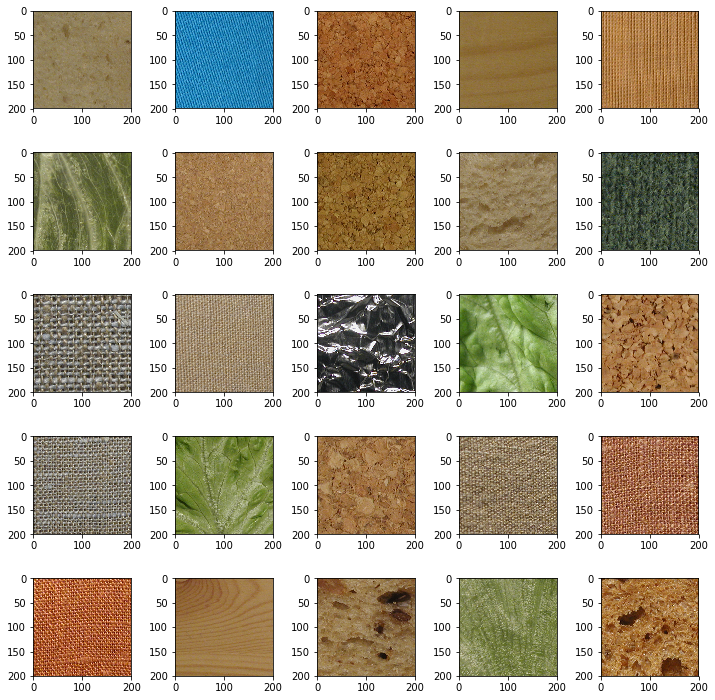

In [7]:
#img_pairs[0][1], train_dataset[0][0].shape, train_ds[0][0].shape

import matplotlib.pyplot as plt
%matplotlib inline

#imgs = np.concatenate([train_ds[i][0].transpose(1,2,0) for i in range(4)])
#plt.imshow(train_ds[0][0].transpose(1,2,0))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
plt.figure(figsize=(10,10))
h = 5
w = 5
target = train_ds
for i in range(h):
    print(' '.join([classes[target[i*w + j][1]] for j in range(w)]))
    for j in range(w):
        pos = i*w + j + 1
        plt.subplot(h, w, pos)
        plt.imshow(target[pos-1][0].transpose(1,2,0))
        #fig, ax = plt.subplots(figsize=(1,1))
        #ax.subplot
        #ax.imshow(train_ds[pos][0].transpose(1,2,0))
#plt.imshow(imgs)
plt.tight_layout()
plt.show()
#x = np.linspace(0, 10, 100)
#y  = np.sin(x)
#plt.plot(x, y)
sleep(0.1)

## 2. Create model

In [18]:
import numpy as np
import chainer
import cupy
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
import time
import random

In [19]:
class LeNetC(chainer.Chain):
    def __init__(self, class_cnt):
        random.seed(0)
        np.random.seed(0)
        cupy.random.seed(0)
        
        super(LeNetC, self).__init__()
        with self.init_scope():
            self.c1 = L.Convolution2D(None, 6, 5, 1, 0) # >28 > 14
            self.c2 = L.Convolution2D(None, 16, 5, 1) # 10 > 5
            #self.c3 = L.Convolution2D(None, 120, 4, 1)  # 1
            self.fc1 = L.Linear(None, 120)
            self.fc2 = L.Linear(None, 84)
            self.fc3 = L.Linear(None, class_cnt)
            
    def __call__(self, x):
        x = F.relu(self.c1(x))
        x = F.max_pooling_2d(x, 2, 2)
        x = F.relu(self.c2(x))
        x = F.max_pooling_2d(x, 2, 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [20]:
class AlexLike(chainer.Chain):
    def __init__(self):
        random.seed(0)
        np.random.seed(0)
        cupy.random.seed(0)
        
        super(AlexLike, self).__init__()
        with self.init_scope():
            self.c1 = L.Convolution2D(None, 96, 11, 4, 2) # >194 > 48
            self.c2 = L.Convolution2D(None, 256, 5, 1, 2) # > 48 > 24
            self.c3 = L.Convolution2D(None, 384, 3, 1, 1) # >12
            self.c4 = L.Convolution2D(None, 384, 3, 1, 1) # >12
            self.c5 = L.Convolution2D(None, 256, 3, 1) # >10 > 5
            self.fc1 = L.Linear(None, 1024) # 3200 > 1024
            self.fc2 = L.Linear(None, 1024)
            self.fc3 = L.Linear(None, 11)
            
    def __call__(self, x):
        x = F.local_response_normalization(F.relu(self.c1(x)))
        x = F.max_pooling_2d(x, 3, 2)
        x = F.local_response_normalization(F.relu(self.c2(x)))
        # x = F.max_pooling_2d(x, 3, 2)
        x = F.relu(self.c3(x))
        x = F.relu(self.c4(x))
        x = F.relu(self.c5(x))
        x = F.max_pooling_2d(x, 3, 2)
        x = F.dropout(F.relu(self.fc1(x)))
        x = F.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        return x


In [31]:
chainer.cuda.get_device_from_id(0).use()

# train_iter = chainer.iterators.SerialIterator(img_dataset, batch_size=10, shuffle=True)
train_iter = chainer.iterators.SerialIterator(train_ds, batch_size=10, shuffle=True)
test_iter = chainer.iterators.SerialIterator(test_ds, batch_size=10, repeat=False, shuffle=False)

In [26]:
train, test = chainer.datasets.get_cifar10()
[train[0][0].shape, train[0][1]], [train_ds[0][0].shape, train_ds[0][1]]
type(train), type(train[0]), type(train_ds), type(train_ds[0]), type(train_dataset), type(train_dataset[0])

(chainer.datasets.tuple_dataset.TupleDataset,
 tuple,
 chainer.datasets.sub_dataset.SubDataset,
 tuple,
 chainer.datasets.sub_dataset.SubDataset,
 tuple)

In [30]:
LeNet = L.Classifier(LeNetC(11))
AlexNet = L.Classifier(AlexLike())
# model_list = [L.GoogLeNet(pretrained_model=None), LeNet, L.GoogLeNet(pretrained_model=None),
#               L.VGG16Layers(pretrained_model=None),
#               L.ResNet50Layers(pretrained_model=None), L.ResNet152Layers(pretrained_model=None)]

model_list = [AlexNet, LeNet]

epoch_cnt = 5
outdir = './kth-tips-result/'

gpu_device = 0
for i, model in enumerate(model_list):
    train_iter.reset()
    test_iter.reset()
    
    # Print model name
    predictor = model.predictor if isinstance(model, L.Classifier) else model
    model_name = predictor.__class__.__name__
    print("#### {0}-{1}".format(i, model_name))

    # Optimizer
    model.to_gpu(0); gpu_device=0
    optimizer = chainer.optimizers.SGD()
    optimizer.setup(model)

    # 
    updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu_device)
    trainer = chainer.training.Trainer(updater, (epoch_cnt, 'epoch'), out=outdir)

    # Extensions
    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_device))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], 'epoch', file_name='acc.png'))
    # trainer.extend(extensions.ParameterStatistics(model))
    # trainer.extend(extensions.ProgressBar())

    # Train
    #start_time = time.time()
    trainer.run()
    #print("  [{0}-{1}] Execution time: {2:.2f} sec".format(i, model_name, time.time() - start_time)), time.sleep(0.01)
    
    chainer.serializers.save_npz(outdir + '{0}-{1}.model'.format(i, model_name), model)


#### 0-AlexLike


epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time


Exception in main training loop: all the input array dimensions except for the concatenation axis must match exactly
Traceback (most recent call last):
  File "C:\Users\tn26o\Anaconda3\envs\py36\lib\site-packages\chainer\training\trainer.py", line 299, in run
    update()
  File "C:\Users\tn26o\Anaconda3\envs\py36\lib\site-packages\chainer\training\updater.py", line 223, in update
    self.update_core()
  File "C:\Users\tn26o\Anaconda3\envs\py36\lib\site-packages\chainer\training\updater.py", line 228, in update_core
    in_arrays = self.converter(batch, self.device)
  File "C:\Users\tn26o\Anaconda3\envs\py36\lib\site-packages\chainer\dataset\convert.py", line 93, in concat_examples
    [example[i] for example in batch], padding[i])))
  File "C:\Users\tn26o\Anaconda3\envs\py36\lib\site-packages\chainer\dataset\convert.py", line 123, in _concat_arrays
    return xp.concatenate([array[None] for array in arrays])
Will finalize trainer extensions and updater before reraising the exception.

ValueError: all the input array dimensions except for the concatenation axis must match exactly